# TP 2 : K-clustering 

Veuillez compilez les deux cellules suivantes.

In [10]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt



In [11]:
## from google.colab import files
## data_to_load1 = files.upload()
## import io
## df_pixels = pd.read_csv(io.BytesIO(data_to_load1['pixels.csv']))

df_pixels = pd.read_csv("pixels.csv")
X = df_pixels.to_numpy(dtype="uint8")

Le but de ce TP est la création d'une classe permettant l'entrainement d'un modèle de K-clustering. Nous allons la construire pas à pas grâce à la méthode du Monkey-Patching.

In [78]:
class MyKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.k = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        
        # Attributs qui seront remplis plus tard
        self.centroids=None 
        self.labels =None

print("Classe initialisée.")

Classe initialisée.


## Exercice 1

La fonction suivante prend pour argument un vecteur de 784 pixels ou une liste de tels vecteurs et affiche la ou les images correspondantes.

In [13]:
def display_image(source):
    if len(source) == 784:
        images = [source]
    elif len(source[0]) == 784:
        images = source
    else:
        print("error")
    
    l = len(images)
    c = math.ceil(l / 3)
    fig, axes = plt.subplots(c, 3, figsize=(12, 5))

    for i, ax in enumerate(axes.flat):
        if i < l:
            img = images[i].reshape(28, 28)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Image {i + 1}")
        ax.axis('off')

Par exemple :

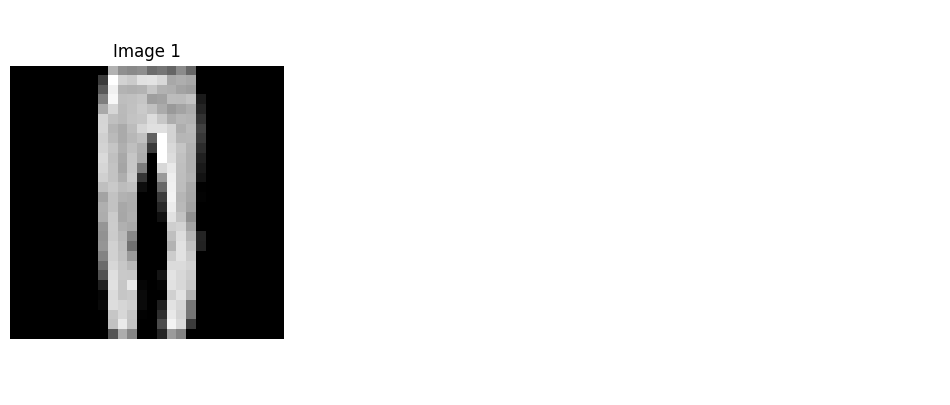

In [14]:
display_image(X[0])

À l'aide de la function `display_image` et de la fonction `mean` (**[documentation](https://numpy.org/doc/2.3/reference/generated/numpy.mean.html)**), affichez l'image moyenne.

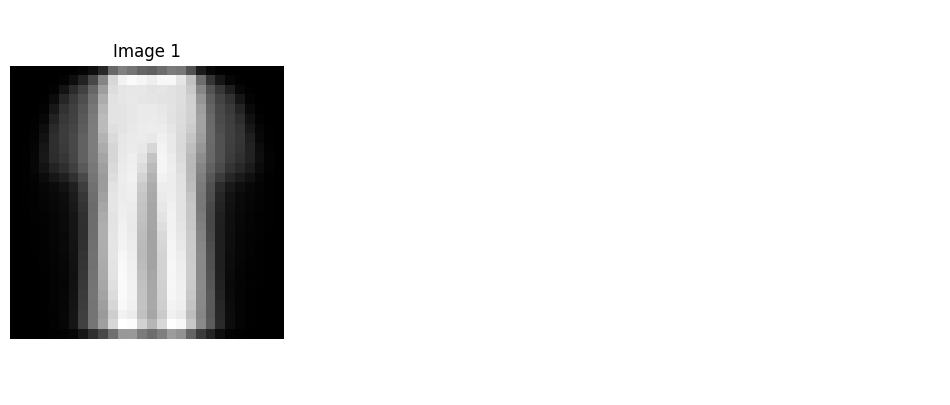

In [15]:
## Écrivez votre code ici.
display_image(np.mean(X, axis=0))

## Exercice 2

Construisez la fonction `random_centroids(data,k)` qui, à partir d'une matrice `data` et d'un entier `k`, renvoit une matrice consitituée de `k`lignes de `data` choisies aléatoirement. Vous pouvez utiliser la fonction `np.random.choice` (**[documentation](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)**).

In [2]:
## Écrivez votre code ici.
def random_centroids(data,k):
    indices=np.random.choice(data.shape[0], size=k, replace=False)
    return data[indices]


Testez votre fonction avec le code suivant.

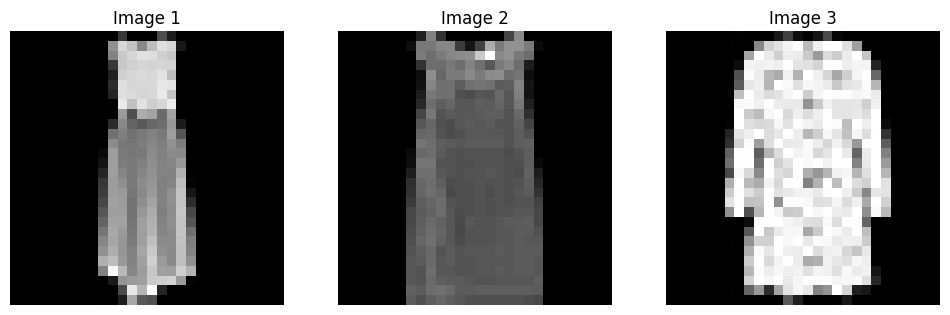

In [29]:
test_centroids = random_centroids(X,3)
display_image(test_centroids)

## Exercice 3

Construisez une fonction `assign_clusters(data,centroids)` qui, à partir d'une matrice `data` et d'une matrice `centroids`, renvoie un vecteur assignant à chaque ligne de `data` l'indice de la ligne de `centroids` avec laquelle elle a la plus petite distance euclidienne. Utilisez les fonctions `np.linalg.norm` (**[documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm)**) et `np.argmin` (**[documentation](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html#numpy-argmin)**) (PAS DE BOUCLE FOR). C'est un exercice de broadcasting. 

In [44]:
## Écrivez votre code ici.
def assign_clusters(data, centroids):
     data = np.array(data)
     centroids = np.array(centroids)
     distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
     return np.argmin(distances, axis=1)

Construisez une fonction `pairing(data,centroids,n)` qui, à partir de matrices `data` et `centroids` ainsi qu'un entier `n`, affiche l'image correspondant à la ligne `n` de `data` et l'image correspondant à la ligne de `centroids` dont elle est la plus proche. 

In [53]:
def pairing(data,centroids,n):
  if n < 0 or n >= data.shape[0]:
        raise ValueError("n doit être un indice valide de data")
  display_image(data[n])
  centroid_points =assign_clusters(data,centroids)
  label=centroid_points[n]
  display_image(centroids[label])
  


Testez votre fonction avec le code suivant.

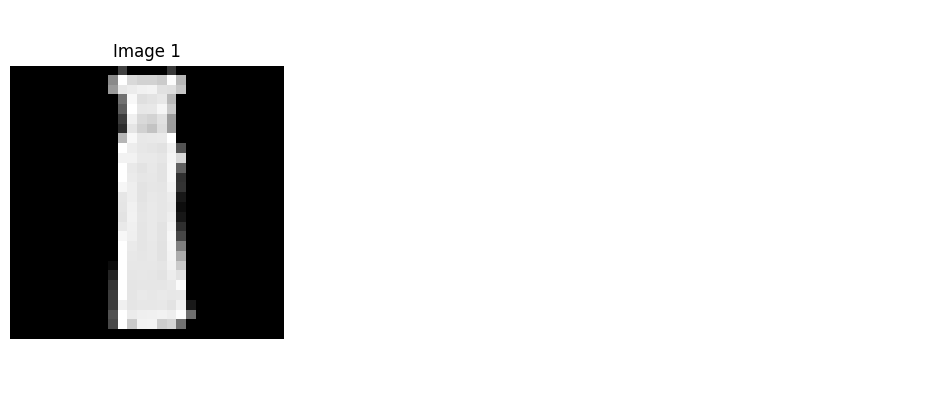

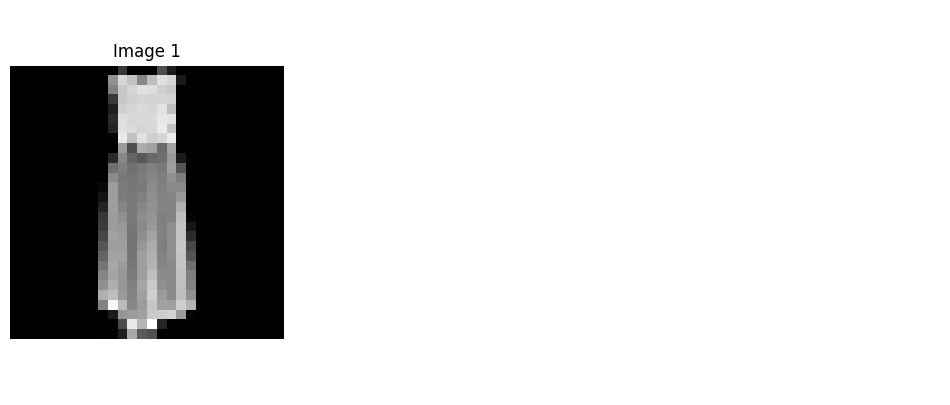

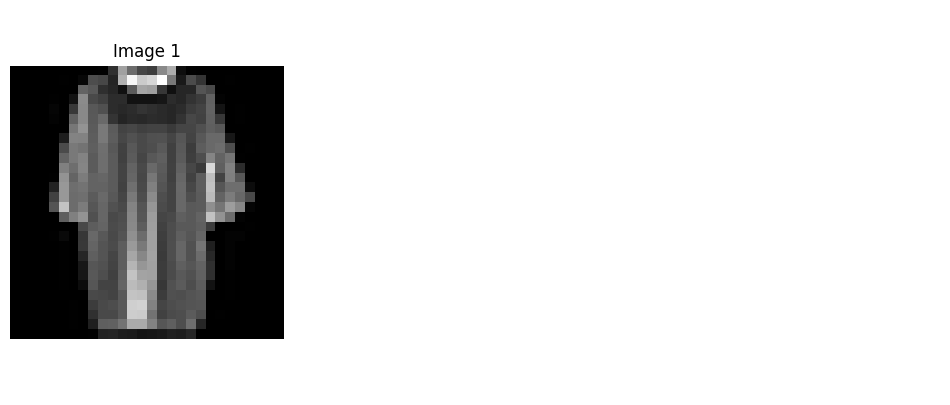

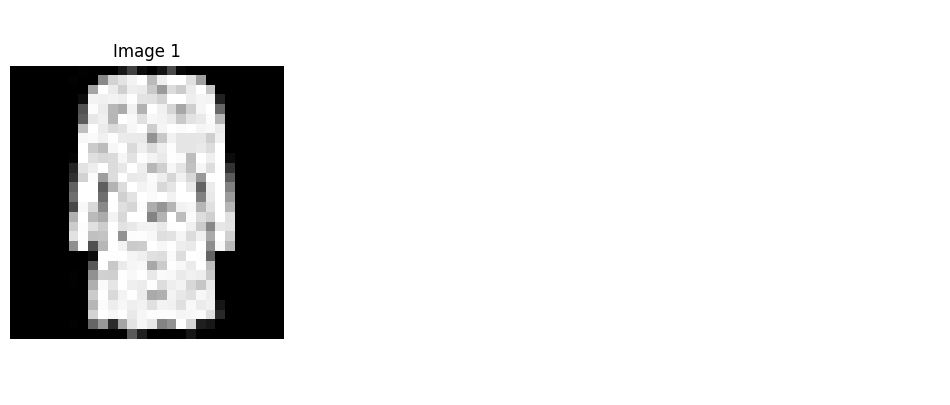

In [66]:
for _ in range(2):
    pairing(X,test_centroids,np.random.choice(range(X.shape[0])))

## Exerice 4

Construisez une fonction `update_centroids(data,k,labels)` qui, à partir d'une matrice `data`, d'un entier `k` et d'un vecteur `labels` assignant à chaque ligne de `data` un indice représentant un centroïde (parmi `k` possibles), renvoie une matrice avec `k` lignes représentant les nouveaux centroïdes après une itération de l'algorithme de Lloyd. 

In [87]:
## Écrivez votre code ici.
## l'algo de lloyd: chaque itération consiste à assigner les points aux centroïdes puis recalculer les centroïdes
## de facon que chaque centroïde soit la moyenne des points qui lui sont assignés
def update_centroids(data, labels, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        points_avec_centroid=data[labels== i]
        if len(points_avec_centroid)>0:
            new_centroids[i]= np.mean(points_avec_centroid, axis=0)
        else:
            new_centroids[i]= data[np.random.choice(data.shape[0])]
    return new_centroids

Testez votre fonction avec le code suivant.

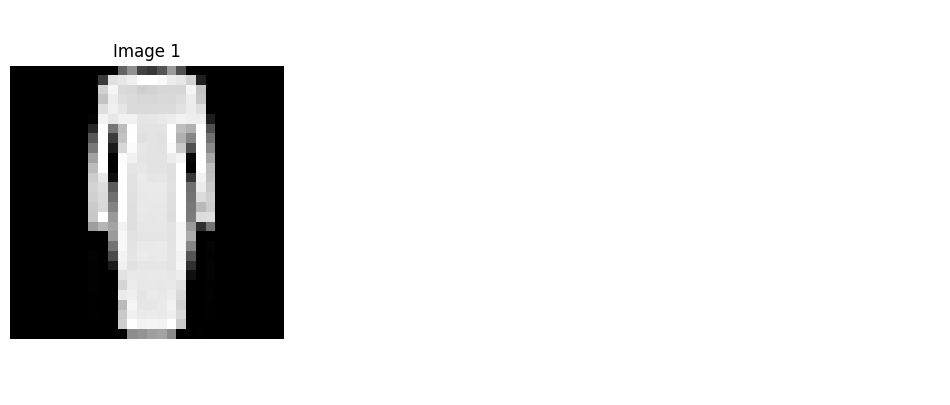

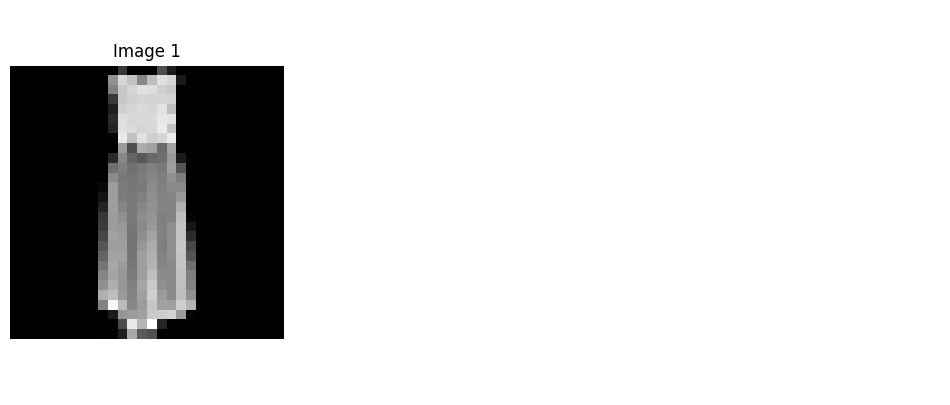

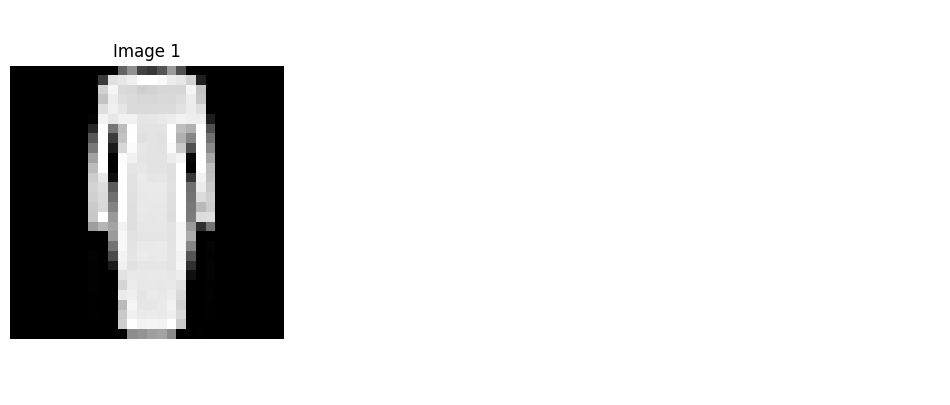

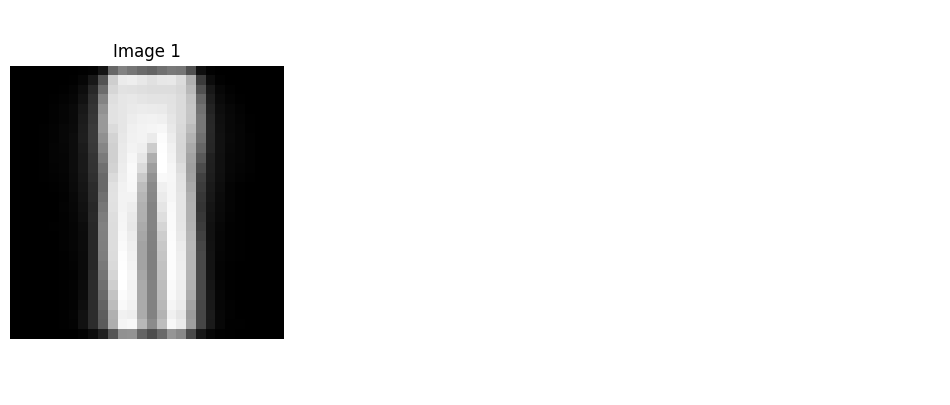

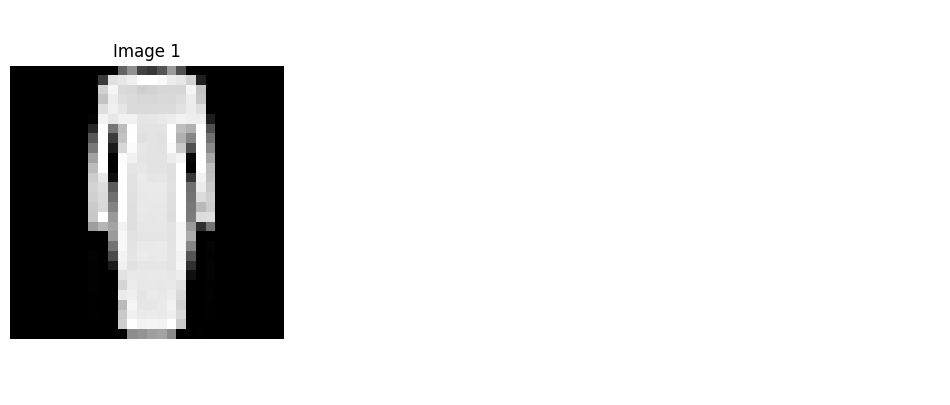

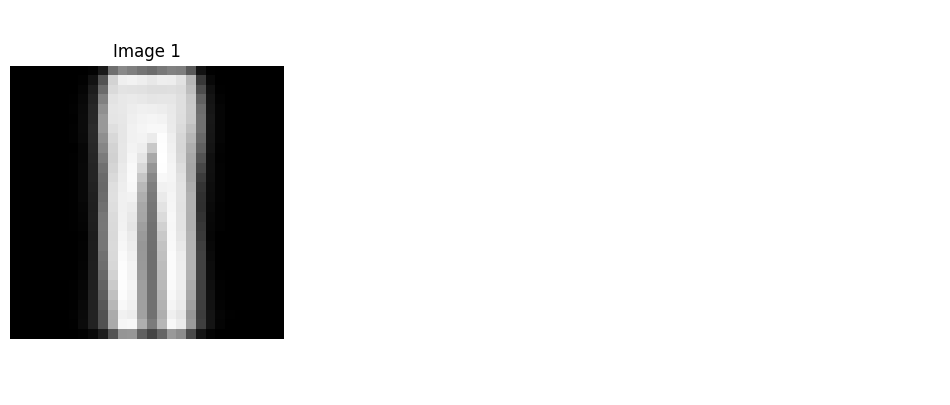

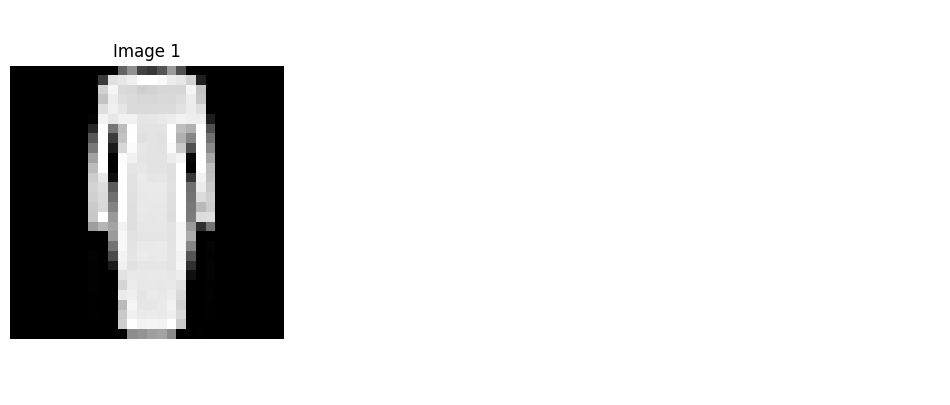

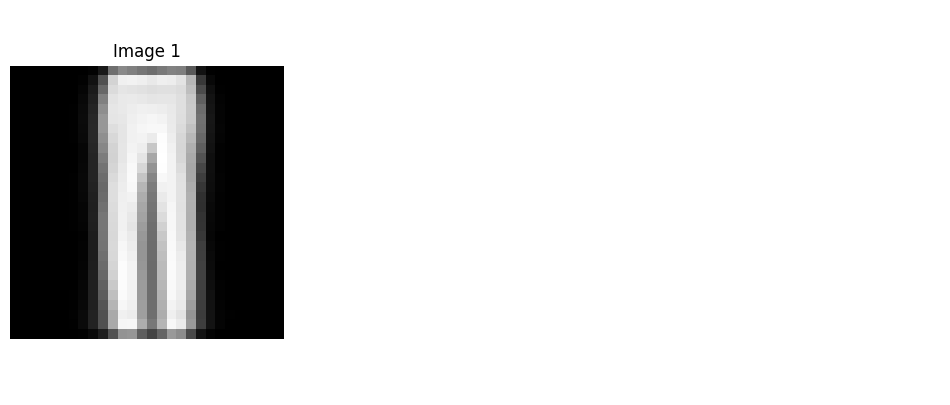

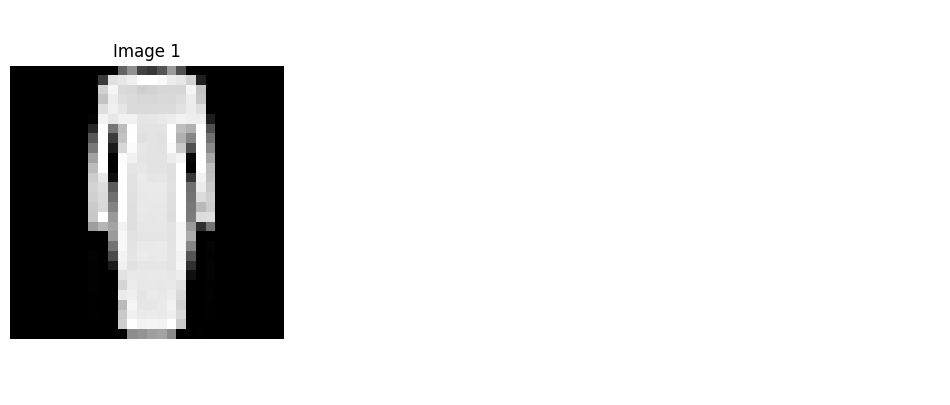

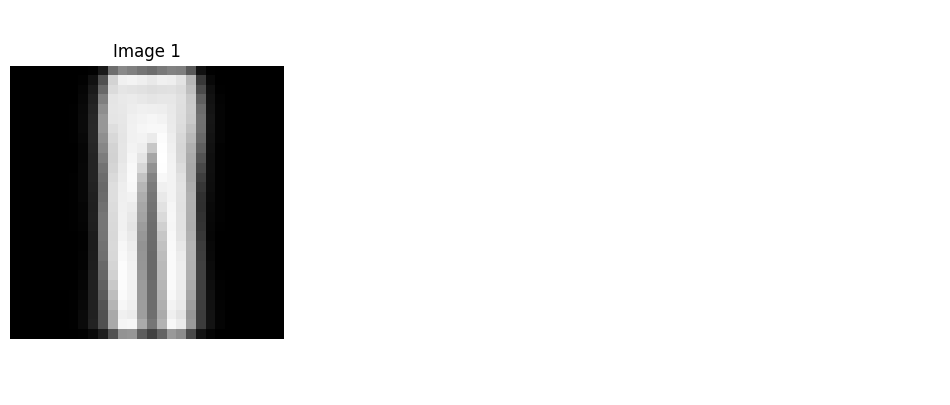

In [88]:
k = 3
current_centroids = test_centroids

for _ in range(5):
    # afficher une image et son centroïde le plus proche
    pairing(X, current_centroids, 156)
    
    # assignation
    labels = assign_clusters(X, current_centroids)
    
    # mise à jour des centroïdes
    current_centroids = update_centroids(X, labels, k)


## Exercice 5

Nous allons commencer le Monkey-Patch de `MyKMeans`. La première étape est de construire une fonction `fit(self,data)` qui utilise l'algorithme de Lloyd pour assigner `self.labels` et `self.centroids` à partir d'une matrice de données `data`. Pour savoir quand arrêter l'algorithme, on utilise la convergence `self.tol` et le nombre maximal d'itération `self.max_iter`. La fonction se termine en affichant la raison de son arrêt ("Convergence atteinte à l'itération n" ou "Nombre maximal d'itération atteint").

In [89]:
def fit(self, X):
## Écrivez votre code ici. 
 centroids=random_centroids(X,self.k)
 centroids = random_centroids(X, self.k)
 if centroids is None:
    raise ValueError("random_centroids n'a pas renvoyé de centroïdes valides")

 for  i in range(self.max_iter):
   labels = assign_clusters(X, centroids)
   new_centroids = update_centroids(X, labels, self.k)
   if new_centroids is None:
    raise ValueError("update_centroids n'a pas renvoyé de centroïdes valides")
   if np.linalg.norm(new_centroids - centroids) < self.tol:
       self.centroids = new_centroids
       self.labels = labels
       print(f"Convergence atteinte après {i+1} itérations.")
       return self
   centroids = new_centroids



 self.labels = labels
 self.centroids = centroids
 print("Nombre maximal d'itérations atteint")
 return self 
 

MyKMeans.fit = fit

Une fois entrainé, un modèle de K-clustering peut aussi classer de nouvelles données. Il suffit de classer chaque vecteur dans la classe correspondant au centroïde dont il est le plus proche. Construisez une fonction `predict(self, new_data)` renvoyant le vecteur d'attribution d'indices de centroïdes. Si le modèle n'a pas encore été entrainé (par la fonction `fit`), faites apparaître un message d'erreur. 

In [90]:
## Écrivez votre code ici.
def predict(self,new_data):
    if self.centroids is None:
        raise ValueError("Le modèle n'a pas encore été entraîné.")
    return assign_clusters(new_data, self.centroids)

## Exercice 5 

Il est temps d'appliquer ce modèle à nos données. Utilisez le code suivant pour classer nos images en trois groupes (en espérant trouver un groupe pour les T-shirts, un groupe pour les pantalons et un groupe pour les robes).

Convergence atteinte après 11 itérations.


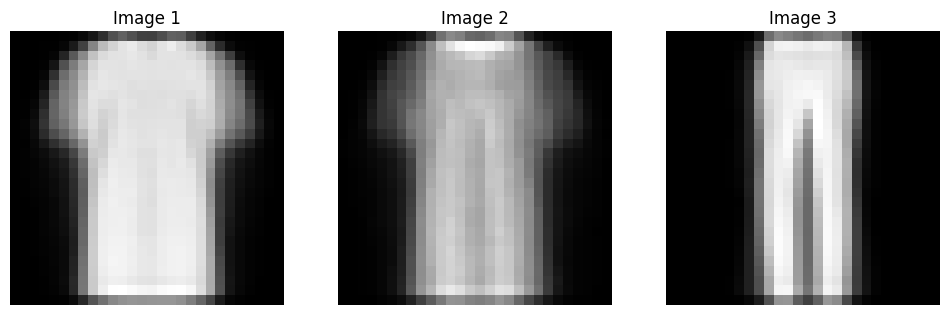

In [91]:
my_km = MyKMeans(n_clusters=3, max_iter=50)
my_km.fit(X)
display_image(my_km.centroids)

Pour évaluer les résulats, nous allons utiliser la véritable classification des données.

In [92]:
## from google.colab import files
## data_to_load2 = files.upload()
## df_labels = pd.read_csv(io.BytesIO(data_to_load1['labels.csv']))

df_label = pd.read_csv("labels.csv")
y = df_label["label"].values

Nous allons représenter les données dans un tableau de contingence croisant la classification du modèle de K-clustering et la véritable classification des images.

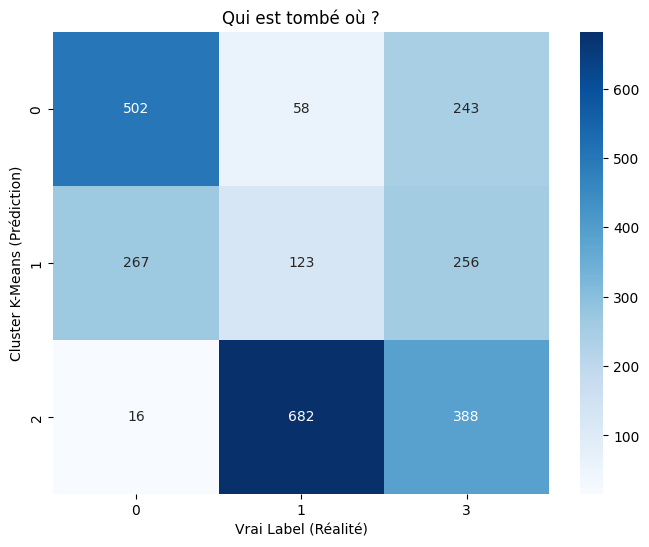

In [ ]:
df_compare = pd.DataFrame({
    'Vrai Label': y,       
    'Cluster KMeans': my_km.labels  
})

ct = pd.crosstab(df_compare['Cluster KMeans'], df_compare['Vrai Label'])

plt.figure(figsize=(8, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues')
plt.title("Qui est tombé où ?")
plt.xlabel("Vrai Label (Réalité)")
plt.ylabel("Cluster K-Means (Prédiction)")
plt.show()

Si la classification était parfait, chaque ligne aurait exactement une case non-vide. Pour estimer à quel point une ligne est parfaite, nous pouvons donc considérer la part des éléments de cette ligne qui sont dans la case qui en contient le plus. En généralisant au tableau entier, nous pouvons estimer la précision du modèle en considérant la part des éléments du tableau qui sont dans la case majoritaire de leur ligne. Appelons cette mesure "précision du modèle".

In [96]:
row_maxes = ct.max(axis=1)
sum_of_maxes = row_maxes.sum()
total_elements = ct.values.sum()
proportion = sum_of_maxes / total_elements

print(f"Précision: {proportion:.2%}")

Précision: 57.24%


Pour améliorer les résultats, nous pouvons augmenter le nombre de centroïdes. Cela revient à découper chaque groupe en plusieurs sous-groupes, en supposant que l'algorithme d'apprentissage non-supervisé est plus efficace pour détecter plusieurs collections homogènes plutôt qu'un ensemble disparate. Construisez une fonction `test_accuracy(n)` créant une instance de `MyKMeans` avec `n` centroïdes, l'entrainant sur `X` et évaluant les résultats avec `y`. La fonction doit renvoyer la précision du modèle.

In [99]:
def test_accuracy(n):
  my_km = MyKMeans(n_clusters=n, max_iter=100)
  my_km.fit(X)
  df_compare = pd.DataFrame({
        'Vrai Label': y,
        'Cluster KMeans': my_km.labels
    })
  ct = pd.crosstab(df_compare['Cluster KMeans'], df_compare['Vrai Label'])
  row_maxes = ct.max(axis=1)          
  sum_of_maxes = row_maxes.sum()      
  total_elements = ct.values.sum()     
  proportion = sum_of_maxes / total_elements
  return f"Précision: {proportion:.2%}"

    

Testez votre fonction avec plusieurs valeurs de `n`. Augmentez `n` pas à pas car l'algorithme pourra prendre beaucoup de temps à tourner pour de hautes valeurs de `n`.

In [112]:
test_accuracy(
    10
)

Convergence atteinte après 26 itérations.


'Précision: 80.04%'